# Capstone 3 

## Preprocessing and Modeling

#### Table of Contents
1. [Preprocessing](#1)
    1. [Sample Weights](#1A)
    2. [Sentiment Rating](#1B)
    3.[Target Encoding](#1C)
    4. [Formatting and Lemmatization](#1D)
    5. [Train Test Split](#1E)
    5. [Count Vectorizer](#1F)
2. [Modeling](#2)
    1. [Logistic Regression](#2A)
    2. [Random Forest](#2B)
    3. [Multinomial Naive Bayes](#2C)
    4. [Support Vector Machines](#2D)
    5. [Model Choice](#2E)


## 1)Preprocessing <a class="anchor" id="1"></a>

In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [214]:
youtube_comments = pd.read_csv('Cap3_EDA.csv')

In [215]:
youtube_comments.columns

Index(['video_id', 'comment_text', 'comment_likes', 'video_title',
       'channel_title', 'video_views', 'video_likes', 'video_comment_count',
       'comments_tokens', 'comments_tokens_size', 'bigrams', 'trigrams'],
      dtype='object')

In [216]:
youtube_comments.drop(['bigrams','trigrams','comments_tokens','comments_tokens_size'], axis = 1, inplace = True)

### A)Sample Weights <a class="anchor" id="1A"></a>

#### i) Comment Likes : Video Views

This weight would weigh the most liked comments within a video higher than less liked videos.  Across videos comments on videos with higher view counts will be penalized.  This will help control for higher video traffic leading to higher like counts.

In [217]:
weights1 = (youtube_comments['comment_likes'] / youtube_comments['video_views']) + 1

In [218]:
data = {'weights1':weights1,
        'comment likes':youtube_comments['comment_likes'],
        'video_views': youtube_comments['video_views']}

weight1_test = pd.DataFrame(data)

weight1_test.sort_values(by='weights1', ascending =False).head(10)

,weights1,comment likes,video_views
12862,1.016343,12093.0,739952
1130,1.010722,471.0,43929
468,1.010273,838.0,81574
467,1.010212,833.0,81574
1598,1.008698,175.0,20119
3400,1.008243,967.0,117313
1325,1.007328,1564.0,213436
12377,1.007177,5489.0,764836
102,1.007164,1347.0,188034
4339,1.007128,860.0,120653


In [219]:
weight1_test['weights1'].describe()

count    13144.000000
mean         1.000212
std          0.000571
min          1.000000
25%          1.000000
50%          1.000025
75%          1.000169
max          1.016343
Name: weights1, dtype: float64

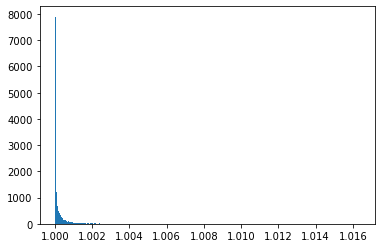

In [220]:
plt.hist(weights1, bins =300)
plt.show()

In [221]:
youtube_comments['weights1'] = weights1

#### ii) Comments Likes : Comment Likes sum by Video

This weight ignores video traffic.  The most liked comments across all videos will be ranked on same scale despite the magnitude of total likes. 

In [222]:
comment_like_totals = pd.DataFrame(youtube_comments.groupby('video_id')['comment_likes'].sum())
comment_like_totals.columns = ['sum']

comment_likes = youtube_comments[['video_id','comment_likes']].merge(comment_like_totals,
                                                                     how = 'left',
                                                                     left_on = 'video_id',
                                                                     right_index =True)

weights2 = (comment_likes['comment_likes']/comment_likes['sum']) + 1 

In [223]:
data = {'weights2':weights2,
        'comment likes':youtube_comments['comment_likes'],
        'video_views': youtube_comments['video_views']}

weight2_test = pd.DataFrame(data)

weight2_test.sort_values(by='weights2', ascending =False).head(10)

,weights2,comment likes,video_views
12377,1.600547,5489.0,764836
11719,1.468755,5356.0,1053573
7090,1.407811,3070.0,695606
4051,1.359984,1801.0,694589
8858,1.359280,4671.0,696380
12862,1.349206,12093.0,739952
11998,1.316897,2847.0,593698
13059,1.286508,361.0,196440
10334,1.259522,2821.0,552430
9720,1.250564,1777.0,976727


In [224]:
weight2_test['weights2'].describe()

count    13144.000000
mean         1.011184
std          0.025997
min          1.000000
25%          1.000000
50%          1.001572
75%          1.010252
max          1.600547
Name: weights2, dtype: float64

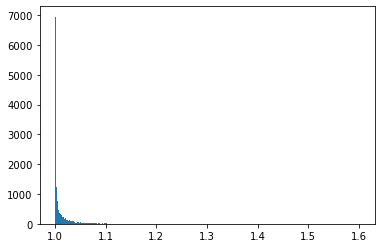

In [225]:
plt.hist(weights2, bins =300)
plt.show()

In [226]:
youtube_comments['weights2'] = weights2

### B)Sentiment Rating<a class="anchor" id="1B"></a>

In [227]:
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kyu_k\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [228]:
sid = SentimentIntensityAnalyzer()

sentiment2 = [sid.polarity_scores(text)['compound'] for text in youtube_comments['comment_text']]

sentiment2 = np.array(sentiment2).reshape(-1, 1)

norm = MinMaxScaler(feature_range=(0,1))

youtube_comments['polarity_vader'] = norm.fit_transform(sentiment2)

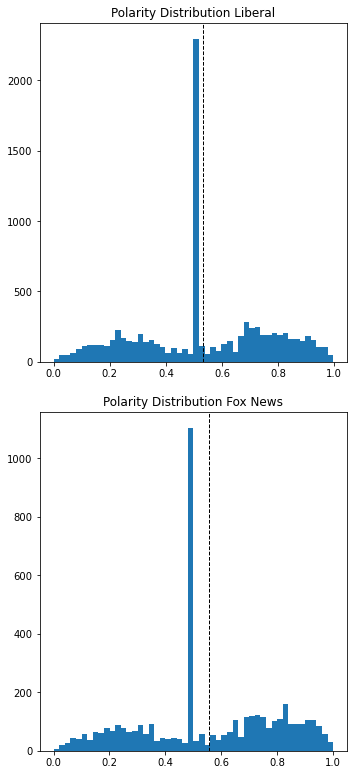

In [229]:

fig, axs = plt.subplots(nrows = 2, ncols =1, figsize=(5,7))
fig.tight_layout()

plt.subplots_adjust(top=1.5)

liberal = (youtube_comments['channel_title']=='CNN') | (youtube_comments['channel_title']=='MSNBC')
conservative = youtube_comments['channel_title']=='Fox News'


axs[0].hist(youtube_comments[liberal]['polarity_vader'], bins =50)
axs[0].title.set_text('Polarity Distribution Liberal')
axs[0].axvline(youtube_comments[liberal]['polarity_vader'].mean(),
               color='k',
               linestyle='dashed',
               linewidth=1)


axs[1].hist(youtube_comments[conservative]['polarity_vader'], bins =50)
axs[1].title.set_text('Polarity Distribution Fox News')
axs[1].axvline(youtube_comments[conservative]['polarity_vader'].mean(), 
               color='k',
               linestyle='dashed',
               linewidth=1)




plt.show()

In [230]:
polarity = [TextBlob(text).sentiment.polarity for text in youtube_comments['comment_text']]
subjectivity = [TextBlob(text).sentiment.subjectivity for text in youtube_comments['comment_text']]


polarity = np.array(polarity).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0,1))
youtube_comments['polarity_blob'] = scaler.fit_transform(polarity)


subjectivity = np.array(subjectivity).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0,1))
youtube_comments['subjectivity_blob'] = scaler.fit_transform(subjectivity)



Polarity is a rating of sentiment.  It lies between -1 (negative) and 1 (positive).  <br/>
Subjectivity is a rating of whether text is trying to represent fact vs opinion.  It lies between 0 (factual) and 1 (opinion).  This a rating of the language used and not the content of the text

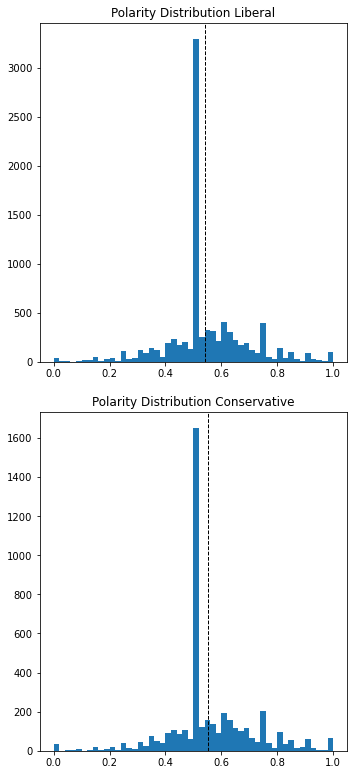

In [231]:

fig, axs = plt.subplots(nrows = 2, ncols =1, figsize=(5,7))
fig.tight_layout()

plt.subplots_adjust(top=1.5)

liberal = (youtube_comments['channel_title']=='CNN') | (youtube_comments['channel_title']=='MSNBC')
conservative = youtube_comments['channel_title']=='Fox News'

axs[0].hist(youtube_comments[liberal]['polarity_blob'], bins =50)
axs[0].title.set_text('Polarity Distribution Liberal')
axs[0].axvline(youtube_comments[liberal]['polarity_blob'].mean(),
               color='k',
               linestyle='dashed',
               linewidth=1)


axs[1].hist(youtube_comments[conservative]['polarity_blob'], bins =50)
axs[1].title.set_text('Polarity Distribution Conservative')
axs[1].axvline(youtube_comments[conservative]['polarity_blob'].mean(), 
               color='k',
               linestyle='dashed',
               linewidth=1)

plt.show()

### C) Target Encoding <a class="anchor" id="1C"></a>

In [232]:
from sklearn.preprocessing import LabelEncoder

In [233]:
conservative = youtube_comments['channel_title']=='Fox News'

youtube_comments['channel_cat'] = ['conservative' if title == 'Fox News' else 'liberal' 
                                   for title in youtube_comments['channel_title']]

youtube_comments['channel_cat'].value_counts()

liberal         8720
conservative    4424
Name: channel_cat, dtype: int64

In [234]:
label_encoder = LabelEncoder()
label_encoder.fit(youtube_comments['channel_cat'])
youtube_comments['channel_cat'] = label_encoder.transform(youtube_comments['channel_cat'])

In [235]:
youtube_comments.sample(3, random_state =343)

,video_id,comment_text,comment_likes,video_title,channel_title,video_views,video_likes,video_comment_count,weights1,weights2,polarity_vader,polarity_blob,subjectivity_blob,channel_cat
12300,2GC86EhnpiQ,When CNN makes a piece agreeing with Trump... ...,6.0,See Trump shut down Covid-19 vaccine skeptic,CNN,3527470,24427,28449,1.000002,1.000099,0.120443,0.40,0.4000,1
5835,lAoRvFnfXB0,"Reading the comments : ""well, no wonders.""\n\n...",1.0,U.S. Reaches 1 Million Daily Covid Cases,MSNBC,33155,314,551,1.000030,1.002132,0.537445,0.65,0.5625,1
2769,EySxIRZdMy8,I have been watching these events unfold like ...,8.0,Former COVID-19 task force czar on Fauci urgin...,Fox News,109656,2694,793,1.000073,1.003083,0.827953,0.75,0.5000,0


In [236]:
labels = label_encoder.classes_
values = label_encoder.transform(label_encoder.classes_)
label_dict = dict(zip(labels, values))

print(label_dict)

{'conservative': 0, 'liberal': 1}


### D) Formatting and Lemmatization <a class="anchor" id="1D"></a>

In [237]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [238]:
lower_yt_comments = [comment.lower() for comment in youtube_comments['comment_text']]

token_yt_comments = [word_tokenize(comment) for comment in lower_yt_comments] 

alpha_only_yt_tokens =  [[token for token in comment if token.isalpha() and len(token)>1] for comment in token_yt_comments] 

no_stop_tokens = [[token for token in comment if token not in stopwords.words('english')] for comment in alpha_only_yt_tokens]

wordnet_lemmatizer = WordNetLemmatizer()

lemma_tokens = [[wordnet_lemmatizer.lemmatize(token) for token in comment] for comment in no_stop_tokens] 

processed_text = [' '.join(token) for token in lemma_tokens]

youtube_comments['processed_text'] = processed_text

### E)Train Test Split<a class="anchor" id="1E"></a>

In order to avoid data leakage with sample weights, I will split the data into train and test sets by the video ids.

In [239]:
from sklearn.model_selection import train_test_split

In [240]:
video_id = youtube_comments['video_id'].unique()

train_id , test_id = train_test_split(video_id,test_size=0.30, random_state=343)

train_id = pd.DataFrame(train_id, columns = ['video_id'])
test_id = pd.DataFrame(test_id, columns = ['video_id'])

train_data = train_id.merge(youtube_comments, how = 'inner', on = 'video_id' )
test_data = test_id.merge(youtube_comments, how = 'inner', on = 'video_id' )

Note: stratify in test train split

In [241]:
print(train_data['channel_cat'].value_counts())
print(test_data['channel_cat'].value_counts())

1    6135
0    3014
Name: channel_cat, dtype: int64
1    2585
0    1410
Name: channel_cat, dtype: int64


In [242]:
X_train = train_data['processed_text']
y_train = train_data['channel_cat']
w1_train = train_data['weights1']
w2_train = train_data['weights2']
sent1_train = train_data[['polarity_blob','subjectivity_blob']]
sent2_train = train_data['polarity_vader']

X_test = test_data['processed_text']
y_test = test_data['channel_cat']
w1_test = test_data['weights1']
w2_test = test_data['weights2']
sent1_test = test_data[['polarity_blob','subjectivity_blob']]
sent2_test = test_data['polarity_vader']

In [243]:
y_train.value_counts(normalize = True)

1    0.670565
0    0.329435
Name: channel_cat, dtype: float64

In [244]:
y_test.value_counts(normalize = True)

1    0.647059
0    0.352941
Name: channel_cat, dtype: float64

### F) Count Vectorizer  <a class="anchor" id="1F"></a>

##### Notes: word2vec?

In [245]:
from sklearn.feature_extraction.text import CountVectorizer

from scipy import sparse

#### Count

In [246]:
count_vect = CountVectorizer(strip_accents = 'ascii')

X_train_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)


In [247]:
def sparse_weight(sparse_mat, weight):
    from scipy import sparse
    
    dense_df = pd.DataFrame(sparse_mat.todense())
    weighted = dense_df.mul(weight, axis = 0)
    
    return (sparse.csr_matrix(weighted))
    

def sparse_concat(sparse_mat, df_toconcat):
    dense_df = pd.DataFrame(sparse_mat.todense())
    concatd = pd.concat([dense_df,df_toconcat], axis =1)
    
    return (sparse.csr_matrix(concatd))
    


In [248]:
X_train_count_w1 = sparse_weight(X_train_count, w1_train)
X_test_count_w1 = sparse_weight(X_test_count, w1_test)

X_train_count_w1_s1 = sparse_concat(X_train_count_w1, sent1_train )
X_test_count_w1_s1 = sparse_concat(X_test_count_w1, sent1_test)

X_train_count_w1_s2 = sparse_concat(X_train_count_w1, sent2_train )
X_test_count_w1_s2 = sparse_concat(X_test_count_w1, sent2_test)

In [249]:
X_train_count_w2 = sparse_weight(X_train_count, w2_train)
X_test_count_w2 = sparse_weight(X_test_count, w2_test)

X_train_count_w2_s1 = sparse_concat(X_train_count_w2, sent1_train )
X_test_count_w2_s1 = sparse_concat(X_test_count_w2, sent1_test)

X_train_count_w2_s2 = sparse_concat(X_train_count_w2, sent2_train )
X_test_count_w2_s2 = sparse_concat(X_test_count_w2, sent2_test)

## 2)Modeling <a class="anchor" id="2"></a>

In [250]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

##### Note : Confusion matrix, classification report, roc curve, auc

In [251]:
def model_eval(model, X_train, y_train, X_test, y_test):
    start_model = model
    start_model.fit(X_train, y_train)
    y_pred = start_model.predict(X_test)
    
    
    plot_confusion_matrix(start_model, X_test, y_test)
    
    plt.xticks(ticks = list(label_dict.values()), labels = list(label_dict.keys()))
    plt.yticks(ticks = list(label_dict.values()), labels = list(label_dict.keys()))
    
    
    plt.show()
    
    print(classification_report(y_test, y_pred))

### A) Logistic Regression <a class="anchor" id="2A"></a>

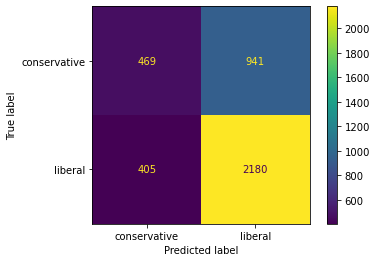

              precision    recall  f1-score   support

           0       0.54      0.33      0.41      1410
           1       0.70      0.84      0.76      2585

    accuracy                           0.66      3995
   macro avg       0.62      0.59      0.59      3995
weighted avg       0.64      0.66      0.64      3995



In [252]:
model_eval(LogisticRegression(max_iter = 1000, random_state =343),
          X_train_count,
          y_train,
          X_test_count,
          y_test)

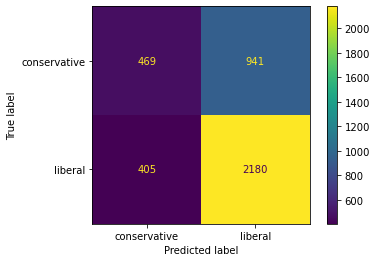

              precision    recall  f1-score   support

           0       0.54      0.33      0.41      1410
           1       0.70      0.84      0.76      2585

    accuracy                           0.66      3995
   macro avg       0.62      0.59      0.59      3995
weighted avg       0.64      0.66      0.64      3995



In [253]:
model_eval(LogisticRegression(max_iter = 1000, random_state =343),
          X_train_count_w1,
          y_train,
          X_test_count_w1,
          y_test)

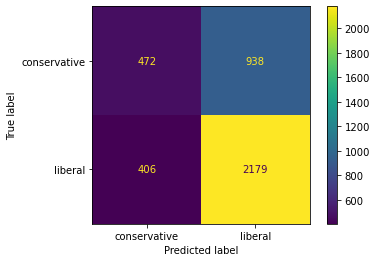

              precision    recall  f1-score   support

           0       0.54      0.33      0.41      1410
           1       0.70      0.84      0.76      2585

    accuracy                           0.66      3995
   macro avg       0.62      0.59      0.59      3995
weighted avg       0.64      0.66      0.64      3995



In [254]:
model_eval(LogisticRegression(max_iter = 1000, random_state =343),
          X_train_count_w1_s1,
          y_train,
          X_test_count_w1_s1,
          y_test)

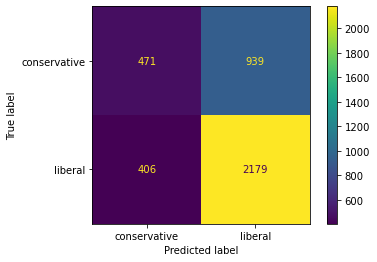

              precision    recall  f1-score   support

           0       0.54      0.33      0.41      1410
           1       0.70      0.84      0.76      2585

    accuracy                           0.66      3995
   macro avg       0.62      0.59      0.59      3995
weighted avg       0.64      0.66      0.64      3995



In [255]:
model_eval(LogisticRegression(max_iter = 1000, random_state =343),
          X_train_count_w1_s2,
          y_train,
          X_test_count_w1_s2,
          y_test)

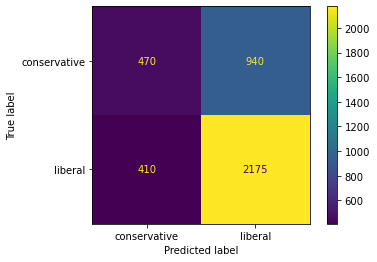

              precision    recall  f1-score   support

           0       0.53      0.33      0.41      1410
           1       0.70      0.84      0.76      2585

    accuracy                           0.66      3995
   macro avg       0.62      0.59      0.59      3995
weighted avg       0.64      0.66      0.64      3995



In [256]:
model_eval(LogisticRegression(max_iter = 1000, random_state =343),
          X_train_count_w2,
          y_train,
          X_test_count_w2,
          y_test)

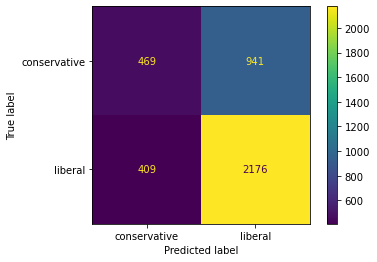

              precision    recall  f1-score   support

           0       0.53      0.33      0.41      1410
           1       0.70      0.84      0.76      2585

    accuracy                           0.66      3995
   macro avg       0.62      0.59      0.59      3995
weighted avg       0.64      0.66      0.64      3995



In [257]:
model_eval(LogisticRegression(max_iter = 1000, random_state =343),
          X_train_count_w2_s1,
          y_train,
          X_test_count_w2_s1,
          y_test)

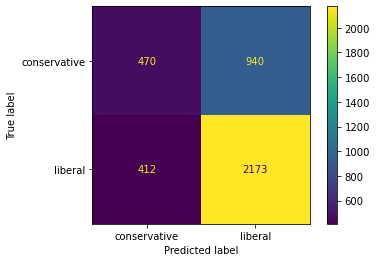

              precision    recall  f1-score   support

           0       0.53      0.33      0.41      1410
           1       0.70      0.84      0.76      2585

    accuracy                           0.66      3995
   macro avg       0.62      0.59      0.59      3995
weighted avg       0.64      0.66      0.64      3995



In [258]:
model_eval(LogisticRegression(max_iter = 1000, random_state =343),
          X_train_count_w2_s2,
          y_train,
          X_test_count_w2_s2,
          y_test)

### B) Random Forest <a class="anchor" id="2B"></a>

In [259]:
from sklearn.ensemble import RandomForestClassifier

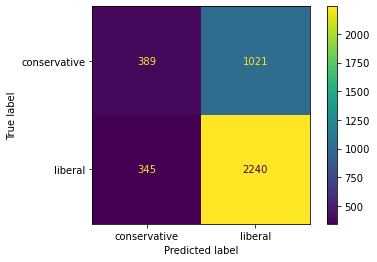

              precision    recall  f1-score   support

           0       0.53      0.28      0.36      1410
           1       0.69      0.87      0.77      2585

    accuracy                           0.66      3995
   macro avg       0.61      0.57      0.56      3995
weighted avg       0.63      0.66      0.62      3995



In [260]:
model_eval(RandomForestClassifier(random_state = 343),
          X_train_count,
          y_train,
          X_test_count,
          y_test)

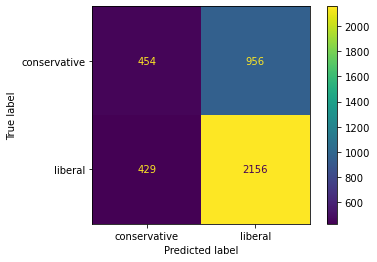

              precision    recall  f1-score   support

           0       0.51      0.32      0.40      1410
           1       0.69      0.83      0.76      2585

    accuracy                           0.65      3995
   macro avg       0.60      0.58      0.58      3995
weighted avg       0.63      0.65      0.63      3995



In [261]:
model_eval(RandomForestClassifier(random_state = 343),
          X_train_count_w1,
          y_train,
          X_test_count_w1,
          y_test)

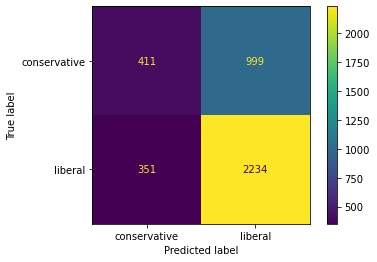

              precision    recall  f1-score   support

           0       0.54      0.29      0.38      1410
           1       0.69      0.86      0.77      2585

    accuracy                           0.66      3995
   macro avg       0.62      0.58      0.57      3995
weighted avg       0.64      0.66      0.63      3995



In [262]:
model_eval(RandomForestClassifier(random_state = 343),
          X_train_count_w1_s1,
          y_train,
          X_test_count_w1_s1,
          y_test)

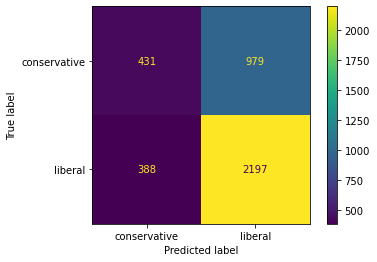

              precision    recall  f1-score   support

           0       0.53      0.31      0.39      1410
           1       0.69      0.85      0.76      2585

    accuracy                           0.66      3995
   macro avg       0.61      0.58      0.57      3995
weighted avg       0.63      0.66      0.63      3995



In [263]:
model_eval(RandomForestClassifier(random_state = 343),
          X_train_count_w1_s2,
          y_train,
          X_test_count_w1_s2,
          y_test)

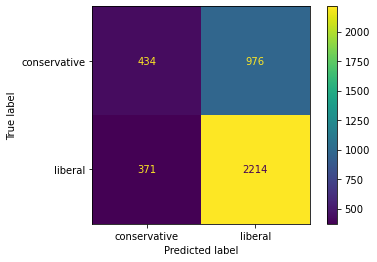

              precision    recall  f1-score   support

           0       0.54      0.31      0.39      1410
           1       0.69      0.86      0.77      2585

    accuracy                           0.66      3995
   macro avg       0.62      0.58      0.58      3995
weighted avg       0.64      0.66      0.63      3995



In [264]:
model_eval(RandomForestClassifier(random_state = 343),
          X_train_count_w2,
          y_train,
          X_test_count_w2,
          y_test)

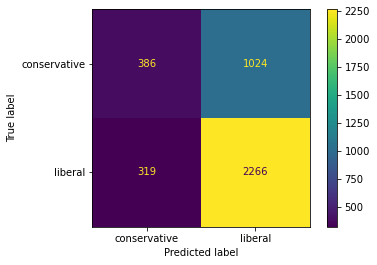

              precision    recall  f1-score   support

           0       0.55      0.27      0.37      1410
           1       0.69      0.88      0.77      2585

    accuracy                           0.66      3995
   macro avg       0.62      0.58      0.57      3995
weighted avg       0.64      0.66      0.63      3995



In [265]:
model_eval(RandomForestClassifier(random_state = 343),
          X_train_count_w2_s1,
          y_train,
          X_test_count_w2_s1,
          y_test)

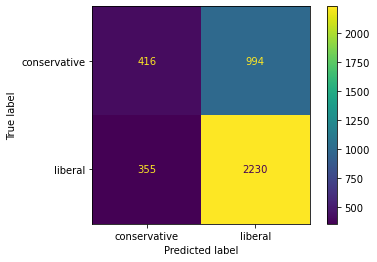

              precision    recall  f1-score   support

           0       0.54      0.30      0.38      1410
           1       0.69      0.86      0.77      2585

    accuracy                           0.66      3995
   macro avg       0.62      0.58      0.57      3995
weighted avg       0.64      0.66      0.63      3995



In [266]:
model_eval(RandomForestClassifier(random_state = 343),
          X_train_count_w2_s2,
          y_train,
          X_test_count_w2_s2,
          y_test)

### C) Multinomial Naive Bayes <a class="anchor" id="2C"></a>

In [267]:
from sklearn.naive_bayes import MultinomialNB

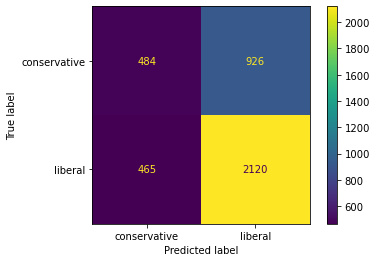

              precision    recall  f1-score   support

           0       0.51      0.34      0.41      1410
           1       0.70      0.82      0.75      2585

    accuracy                           0.65      3995
   macro avg       0.60      0.58      0.58      3995
weighted avg       0.63      0.65      0.63      3995



In [268]:
model_eval(MultinomialNB(),
          X_train_count,
          y_train,
          X_test_count,
          y_test)

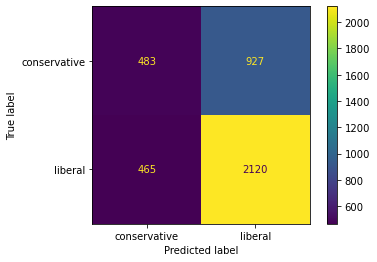

              precision    recall  f1-score   support

           0       0.51      0.34      0.41      1410
           1       0.70      0.82      0.75      2585

    accuracy                           0.65      3995
   macro avg       0.60      0.58      0.58      3995
weighted avg       0.63      0.65      0.63      3995



In [269]:
model_eval(MultinomialNB(),
          X_train_count_w1,
          y_train,
          X_test_count_w1,
          y_test)

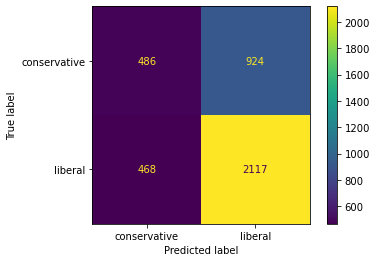

              precision    recall  f1-score   support

           0       0.51      0.34      0.41      1410
           1       0.70      0.82      0.75      2585

    accuracy                           0.65      3995
   macro avg       0.60      0.58      0.58      3995
weighted avg       0.63      0.65      0.63      3995



In [270]:
model_eval(MultinomialNB(),
          X_train_count_w2,
          y_train,
          X_test_count_w2,
          y_test)

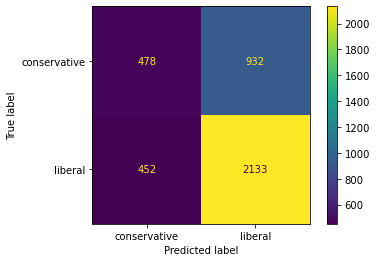

              precision    recall  f1-score   support

           0       0.51      0.34      0.41      1410
           1       0.70      0.83      0.76      2585

    accuracy                           0.65      3995
   macro avg       0.60      0.58      0.58      3995
weighted avg       0.63      0.65      0.63      3995



In [271]:

model_eval(MultinomialNB(),
          X_train_count_w1_s1,
          y_train,
          X_test_count_w1_s1,
          y_test)

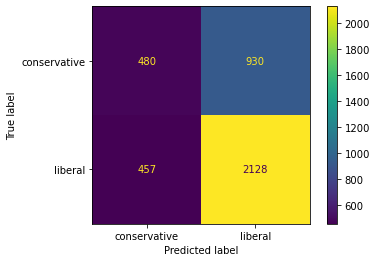

              precision    recall  f1-score   support

           0       0.51      0.34      0.41      1410
           1       0.70      0.82      0.75      2585

    accuracy                           0.65      3995
   macro avg       0.60      0.58      0.58      3995
weighted avg       0.63      0.65      0.63      3995



In [272]:
model_eval(MultinomialNB(),
          X_train_count_w1_s2,
          y_train,
          X_test_count_w1_s2,
          y_test)

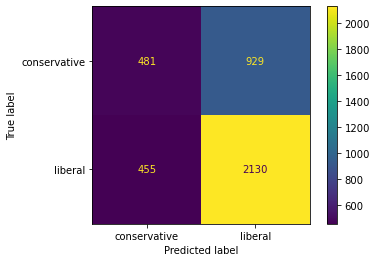

              precision    recall  f1-score   support

           0       0.51      0.34      0.41      1410
           1       0.70      0.82      0.75      2585

    accuracy                           0.65      3995
   macro avg       0.61      0.58      0.58      3995
weighted avg       0.63      0.65      0.63      3995



In [273]:
model_eval(MultinomialNB(),
          X_train_count_w2_s1,
          y_train,
          X_test_count_w2_s1,
          y_test)

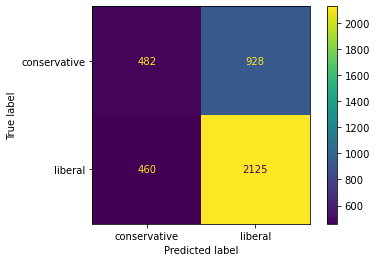

              precision    recall  f1-score   support

           0       0.51      0.34      0.41      1410
           1       0.70      0.82      0.75      2585

    accuracy                           0.65      3995
   macro avg       0.60      0.58      0.58      3995
weighted avg       0.63      0.65      0.63      3995



In [274]:
model_eval(MultinomialNB(),
          X_train_count_w2_s2,
          y_train,
          X_test_count_w2_s2,
          y_test)

### D) Support Vector Machines <a class="anchor" id="2D"></a>

In [275]:
from sklearn.svm import SVC

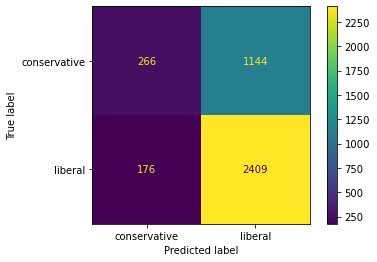

              precision    recall  f1-score   support

           0       0.60      0.19      0.29      1410
           1       0.68      0.93      0.78      2585

    accuracy                           0.67      3995
   macro avg       0.64      0.56      0.54      3995
weighted avg       0.65      0.67      0.61      3995



In [276]:
model_eval(SVC(random_state = 343),
          X_train_count,
          y_train,
          X_test_count,
          y_test)

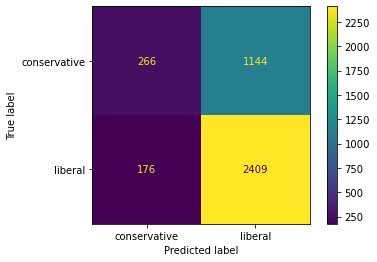

              precision    recall  f1-score   support

           0       0.60      0.19      0.29      1410
           1       0.68      0.93      0.78      2585

    accuracy                           0.67      3995
   macro avg       0.64      0.56      0.54      3995
weighted avg       0.65      0.67      0.61      3995



In [277]:
model_eval(SVC(random_state = 343),
          X_train_count_w1,
          y_train,
          X_test_count_w1,
          y_test)

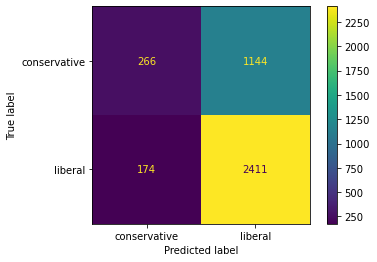

              precision    recall  f1-score   support

           0       0.60      0.19      0.29      1410
           1       0.68      0.93      0.79      2585

    accuracy                           0.67      3995
   macro avg       0.64      0.56      0.54      3995
weighted avg       0.65      0.67      0.61      3995



In [278]:
model_eval(SVC(random_state = 343),
          X_train_count_w2,
          y_train,
          X_test_count_w2,
          y_test)

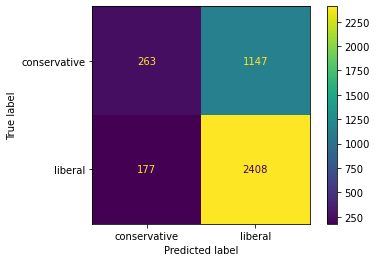

              precision    recall  f1-score   support

           0       0.60      0.19      0.28      1410
           1       0.68      0.93      0.78      2585

    accuracy                           0.67      3995
   macro avg       0.64      0.56      0.53      3995
weighted avg       0.65      0.67      0.61      3995



In [279]:
model_eval(SVC(random_state = 343),
          X_train_count_w1_s1,
          y_train,
          X_test_count_w1_s1,
          y_test)

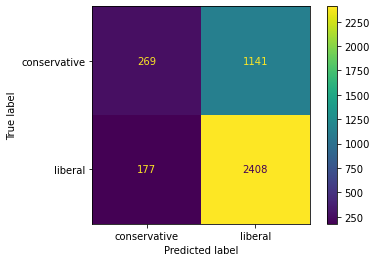

              precision    recall  f1-score   support

           0       0.60      0.19      0.29      1410
           1       0.68      0.93      0.79      2585

    accuracy                           0.67      3995
   macro avg       0.64      0.56      0.54      3995
weighted avg       0.65      0.67      0.61      3995



In [280]:
model_eval(SVC(random_state = 343),
          X_train_count_w1_s2,
          y_train,
          X_test_count_w1_s2,
          y_test)

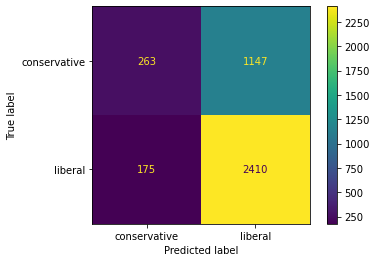

              precision    recall  f1-score   support

           0       0.60      0.19      0.28      1410
           1       0.68      0.93      0.78      2585

    accuracy                           0.67      3995
   macro avg       0.64      0.56      0.53      3995
weighted avg       0.65      0.67      0.61      3995



In [281]:
model_eval(SVC(random_state = 343),
          X_train_count_w2_s1,
          y_train,
          X_test_count_w2_s1,
          y_test)

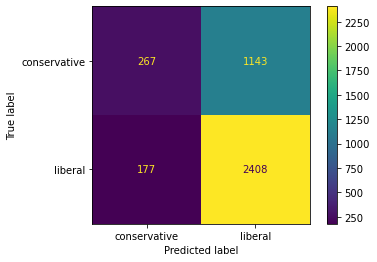

              precision    recall  f1-score   support

           0       0.60      0.19      0.29      1410
           1       0.68      0.93      0.78      2585

    accuracy                           0.67      3995
   macro avg       0.64      0.56      0.54      3995
weighted avg       0.65      0.67      0.61      3995



In [282]:
model_eval(SVC(random_state = 343),
          X_train_count_w2_s2,
          y_train,
          X_test_count_w2_s2,
          y_test)

### E) Model Choice <a class="anchor" id="2E"></a>

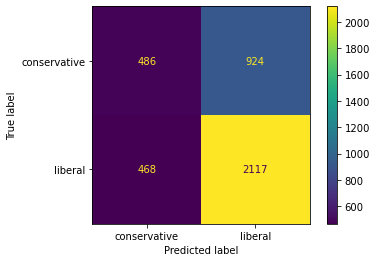

              precision    recall  f1-score   support

           0       0.51      0.34      0.41      1410
           1       0.70      0.82      0.75      2585

    accuracy                           0.65      3995
   macro avg       0.60      0.58      0.58      3995
weighted avg       0.63      0.65      0.63      3995



In [283]:
model_eval(MultinomialNB(),
          X_train_count_w2,
          y_train,
          X_test_count_w2,
          y_test)

Out of the four models Multinomial Naive Bayes, Support Vector Machines, Logistic Regression, and Random Forest Classifier, Multinomial Naive Bayes was chosen to be the best performing models.  The second weighting scheme was used to weight count vectors.  All the models had similar perfomance, with accuracies between 65 - 67%. 
    The chosen model had the higher F1 scores as well, despite having a lower accuracy.  So overall this model was better at identifying both classes all around.  For example SVM had one of the highest accuracies but had a low F1 score for the Conservative classification.   